In [1]:
import warnings
import pandas as pd
import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score
from pyspark.ml.regression import LinearRegression
from pyspark.ml.linalg import Vectors
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

In [2]:
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
df = pd.read_csv('btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df.sort_values('DateTime')
df.head()
df.set_index('DateTime',inplace=True)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

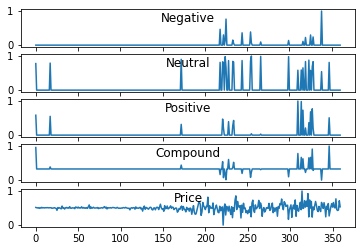

In [6]:
values = scaled

# specify columns to plot
groups = [0,1,2,3,4]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='center')
    i += 1
plt.show()

In [7]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,Price,Negative,Neutral,Positive,Compound
DateTime,,,,,
2020-07-01,144.8,0.0,0.741,0.259,0.8126
2020-07-02,18.0,0.0,0.000,0.000,0.0000
2020-07-03,-67.3,0.0,0.000,0.000,0.0000
2020-07-04,53.4,0.0,0.000,0.000,0.0000
2020-07-05,-258.0,0.0,0.000,0.000,0.0000


In [8]:
n_days = 1       
reframed = series_to_supervised(scaled, n_days, 1) 
reframed = reframed.drop(reframed.columns[-4:], axis=1)  #dropping all the present values except present price
cols = reframed.columns.tolist()
cols = cols[-1:] + cols[:-1] #just making the price as the first column
reframed = reframed[cols]
reframed.info()
reframed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359 entries, 1 to 359
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t)    359 non-null    float64
 1   var1(t-1)  359 non-null    float64
 2   var2(t-1)  359 non-null    float64
 3   var3(t-1)  359 non-null    float64
 4   var4(t-1)  359 non-null    float64
 5   var5(t-1)  359 non-null    float64
dtypes: float64(6)
memory usage: 19.6 KB


,var1(t),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.0,0.0,0.77918,0.583333,0.956370,0.517534
2,0.0,0.0,0.00000,0.000000,0.326643,0.508997
3,0.0,0.0,0.00000,0.000000,0.326643,0.503255
4,0.0,0.0,0.00000,0.000000,0.326643,0.511381
5,0.0,0.0,0.00000,0.000000,0.326643,0.490417


In [9]:
train_size = 0.7
train_end = int(len(reframed)*train_size)

df_shuffled = shuffle(reframed)

df_train = df_shuffled[:train_end]
df_test = df_shuffled[train_end:]

reg_DF_train = sql.createDataFrame(df_train)
ad_df_train = reg_DF_train.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])

reg_DF_test = sql.createDataFrame(df_test)
ad_df_test = reg_DF_test.rdd.map(lambda x: [Vectors.dense(x[1:]), x[0]]).toDF(['features', 'label'])

lr = LinearRegression(featuresCol = 'features', labelCol = 'label')
lr_model = lr.fit(ad_df_train)
print('Y = {}X {}'.format(lr_model.coefficients,lr_model.intercept))

predictions = lr_model.transform(ad_df_test)
predictions = predictions.toPandas()
predictions.head()

Y = [-0.3559197405080401,0.1984909195839846,-0.10205832961554254,-0.0013704543903855634,-0.04486146680373095]X 0.031245708785593004


,features,label,prediction
0,"[0.0, 0.0, 0.0, 0.32664290142591446, 0.5091387...",0.0,0.007957
1,"[0.0, 0.0, 0.0, 0.32664290142591446, 0.2387254...",0.0,0.020088
2,"[0.0, 0.0, 0.0, 0.32664290142591446, 0.2852170...",0.0,0.018003
3,"[0.0, 0.0, 0.0, 0.32664290142591446, 0.5303380...",0.0,0.007006
4,"[0.0, 0.0, 0.0, 0.32664290142591446, 0.4801505...",0.0,0.009258


Coeficiente de Determinação (R2): -0.338203539884101


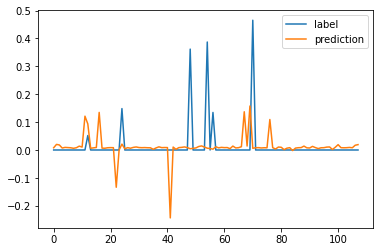

In [11]:
predictions.plot()

R_2 = r2_score(predictions['label'].values, predictions['prediction'].values)  #realiza o cálculo do R2
print("Coeficiente de Determinação (R2):", R_2)